In [31]:
import numpy as np
import warnings
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler

In [3]:
wine = pd.read_csv("~/ucare-summer2020/datasets/winequality-white.csv", sep=";")

In [4]:
X = wine.drop(columns=['quality'])
y = wine['quality']
y = y > 5
y = y.astype(int)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [6]:
X_train.shape

(3918, 11)

In [7]:
neighbors = np.arange(1,300)

# Two arrays to store training and test accuracies
train_accuracy = np.empty(len(neighbors))
validation_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    
    # Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Fit the model
    knn.fit(X_train, y_train)
    
    
    # The "score" function returns the mean accuracy on the given train/test data and labels.
    # Note that "accuracy" may not be a good performance measure in a skewed data set
    # Thus, we need to do hyperparameter tuning by using better performance measures (e.g., f1 score, presision, recall)
    
    # Compute training accuracy 
    train_accuracy[i] = knn.score(X_train, y_train)
    
    # Compute validation accuracy using cross-validation
    
    scores = cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=5)
    
    validation_accuracy[i] = scores.mean()

NameError: name 'neighbors' is not defined

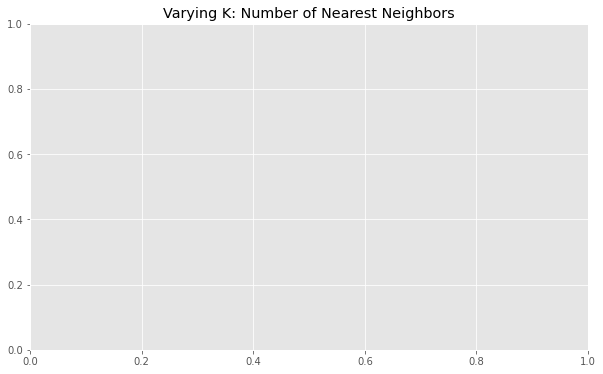

In [7]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 6))
plt.title('Varying K: Number of Nearest Neighbors')
plt.plot(neighbors, validation_accuracy, label='Validation Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('K (Number of Nearest Neighbors)')
plt.ylabel('Accuracy')
plt.show()



# Find the value of "K" that gives max validation accuracy
j = 0
max_val_accuracy = validation_accuracy[j]
max_k = 1

for i in neighbors:
    if(validation_accuracy[j] > max_val_accuracy):
        max_val_accuracy = validation_accuracy[j]
        max_k = i
    j +=1
    
print("Optimal K: ", max_k)

In [20]:
%%time
warnings.filterwarnings('ignore')

# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values
param_grid = {'n_neighbors': np.arange(1,10), 'p': [1, 2, 10, 50, 100, 500, 1000], 
              'weights': ["uniform", "distance"]}

knn_clf = KNeighborsClassifier()

knn_cv = GridSearchCV(knn_clf, param_grid, scoring='f1', cv=5, verbose=3, n_jobs=-1)
knn_cv.fit(X_train, y_train)


params_optimal_knn = knn_cv.best_params_

print("Best Score: %f" % knn_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_knn)
print("\n")

Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:   13.8s


Best Score: 0.827443
Optimal Hyperparameter Values:  {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}


CPU times: user 759 ms, sys: 108 ms, total: 867 ms
Wall time: 28.1 s


[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:   28.0s finished


In [21]:
knn = KNeighborsClassifier(**params_optimal_knn)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9, p=1, weights='distance')

In [25]:
scores = cross_val_score(knn, X_train, y_train, scoring='f1', cv=5)
accuracy = cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=5)
print(scores)
print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

print("Accuracy: " + str(accuracy.mean()))

[0.83489681 0.82904412 0.82084095 0.83865087 0.81378026]
F1 Score: 0.83 (+/- 0.02)
Accuracy: 0.7613567649281935


In [28]:
y_train_pred = cross_val_predict(knn, X_train, y_train, cv=5)

confusion_matrix(y_train, y_train_pred)

array([[ 741,  578],
       [ 357, 2242]])

In [29]:
precision = precision_score(y_train, y_train_pred) 
print("Precision = %f" % precision)

recall = recall_score(y_train, y_train_pred)
print("Recall = %f" % recall)


f1 = f1_score(y_train, y_train_pred)
print("F1 Score = %f" % f1)

Precision = 0.795035
Recall = 0.862639
F1 Score = 0.827459


In [33]:
y_scores = cross_val_predict(knn, X_train, y_train, method="predict_proba", cv=5)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

print("\nFPR FPR & TPR for Various Threshold Values:")

print("FPR: ", fpr)
print("TPR: ", tpr)
print("\nThresholds: ", thresholds)


FPR FPR & TPR for Various Threshold Values:
FPR:  [0.         0.03335861 0.03335861 ... 0.73009856 0.73995451 1.        ]
TPR:  [0.         0.39130435 0.39361293 ... 0.99807618 0.99807618 1.        ]

Thresholds:  [2.         1.         0.96707035 ... 0.08277134 0.01282646 0.        ]


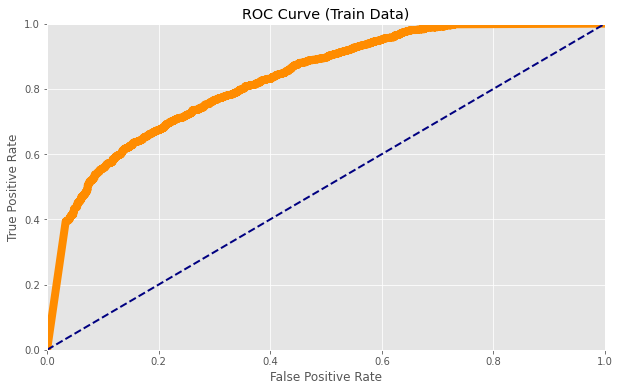

In [34]:
plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 6))
def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, color='darkorange', linewidth=8, label=label) 
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.axis([0, 1, 0, 1])
    plt.title('ROC Curve (Train Data)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

In [35]:
roc_auc_score(y_train,y_scores)


0.8288740843638176

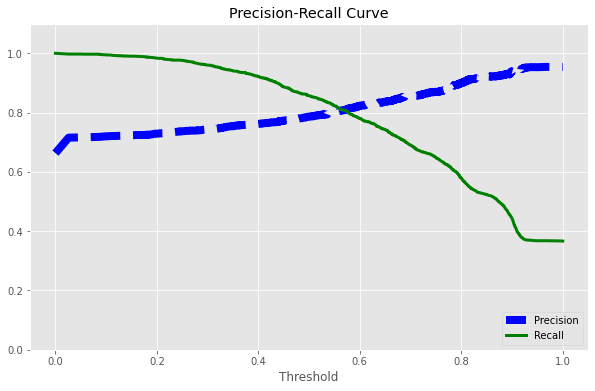

Optimal Threshold:  0.5683203915948767


In [36]:
plt.style.use('ggplot')

# Get the 2nd column of the matrix of predicted probabilities for each data point
#    The 2nd column stores the probalities of the positive class
y_scores = cross_val_predict(knn, X_train, y_train, method="predict_proba", cv=3)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)


fig = plt.figure(figsize=(10, 6))
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.plot(thresholds, precisions[:-1], "b--",  linewidth=8, label="Precision") 
    plt.plot(thresholds, recalls[:-1], "g-",  linewidth=3, label="Recall") 
    plt.xlabel("Threshold")
    plt.legend(loc="lower right")
    plt.title('Precision-Recall Curve')
    #plt.xlim([0, 1])
    plt.ylim([0, 1.1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()


threshold_optimal = -1
for i in range(len(precisions)):
    if(precisions[i] == recalls[i]):
        threshold_optimal = thresholds[i]

print("Optimal Threshold: ", threshold_optimal)

In [37]:
print("Performance Measures Based on the Default Threshold:\n")


y_train_pred = cross_val_predict(knn, X_train, y_train, cv=5)

# Precision, Recall, F1 Score and Confusion Matrix for the Default Threshold 0.5
precision_train = precision_score(y_train, y_train_pred) 
print("Precision (Default Threshold 0.5) = %f" % precision_train)

recall_train = recall_score(y_train, y_train_pred)
print("Recall (Default Threshold 0.5) = %f" % recall_train)


f1_train = f1_score(y_train, y_train_pred)
print("F1 Score (Default Threshold 0.5) = %f" % f1_train)

print("Confusion Matrix (Default Threshold 0.5)\n", confusion_matrix(y_train, y_train_pred))


print("\n-------------------------------------------------------\n")
print("Performance Measures Based on the Optimal Threshold (from Precision-Recall Curve):")

# Precision, Recall, F1 Score and Confusion Matrix for different threshold

t = threshold_optimal # optimal threshold from precision-recall curve 

# Compute predictions based on new t by using the following method:
#  - Get the probability of the positive class from the 2nd column [:, 1]
#  - If that probability is greater than or equal to t, then the test data belongs to the positive class
y_train_predicted_new = (cross_val_predict(knn, X_train, y_train, method="predict_proba", cv=3)[:,1] > t).astype(int)


precision = precision_score(y_train, y_train_predicted_new) 
print("\nPrecision (Threshold %.2f) = %f" % (t, precision))

recall = recall_score(y_train, y_train_predicted_new)
print("Recall (Threshold %.2f) = %f" % (t, recall))


f1 = f1_score(y_train, y_train_predicted_new)
print("F1 Score = (Threshold %.2f) = %f" % (t, f1))


print("Confusion Matrix (Threshold %.2f)" %  t) 
print(confusion_matrix(y_train, y_train_predicted_new))

Performance Measures Based on the Default Threshold:

Precision (Default Threshold 0.5) = 0.795035
Recall (Default Threshold 0.5) = 0.862639
F1 Score (Default Threshold 0.5) = 0.827459
Confusion Matrix (Default Threshold 0.5)
 [[ 741  578]
 [ 357 2242]]

-------------------------------------------------------

Performance Measures Based on the Optimal Threshold (from Precision-Recall Curve):

Precision (Threshold 0.57) = 0.808314
Recall (Threshold 0.57) = 0.808003
F1 Score = (Threshold 0.57) = 0.808159
Confusion Matrix (Threshold 0.57)
[[ 821  498]
 [ 499 2100]]


In [38]:
# The accuracy of the model
test_accuracy_knn = knn.score(X_test, y_test)
print("\nTest Accuracy: ", test_accuracy_knn)


# No. of Correct Predictions
y_test_predicted = knn.predict(X_test)
print("\nNo. of correct predictions (Test): %d/%d" % (np.sum(y_test_predicted == y_test), len(y_test)))



# Confusion Matrix
print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test, y_test_predicted))


Test Accuracy:  0.7846938775510204

No. of correct predictions (Test): 769/980

Confusion Matrix (Test Data):
 [[188 133]
 [ 78 581]]


In [39]:
precision = precision_score(y_test, y_test_predicted) 
print("Precision = %f" % precision)

recall = recall_score(y_test, y_test_predicted)
print("Recall = %f" % recall)


f1 = f1_score(y_test, y_test_predicted)
print("F1 Score = %f" % f1)

Precision = 0.813725
Recall = 0.881639
F1 Score = 0.846322


In [41]:
# Get the 2nd column of the matrix of predicted probabilities for each data point
#    The 2nd column stores the probalities of the positive class
y_scores_test = cross_val_predict(knn, X_test, y_test, method="predict_proba", cv=3)[:, 1]

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_scores_test)

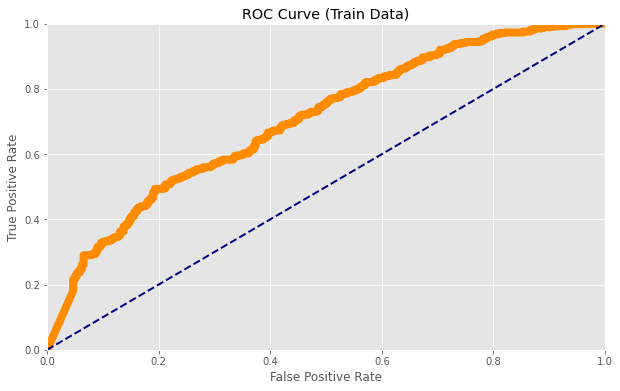

In [42]:
plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 6))
plot_roc_curve(fpr_test, tpr_test)
plt.show()

In [43]:
roc_auc_score(y_test,y_scores_test)

0.7022133034570458

In [44]:
pd.crosstab(y_test, y_test_predicted, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,188,133,321
1,78,581,659
All,266,714,980


In [45]:
print(classification_report(y_test,y_test_predicted))


              precision    recall  f1-score   support

           0       0.71      0.59      0.64       321
           1       0.81      0.88      0.85       659

    accuracy                           0.78       980
   macro avg       0.76      0.73      0.74       980
weighted avg       0.78      0.78      0.78       980



In [75]:
def knn_report(feature1, feature2):
    eff_X = X.loc[:, [feature1, feature2]]
    eff_X_test = X_test.loc[:, [feature1, feature2]]
    eff_X_train = X_train.loc[:, [feature1, feature2]]
    
    param_grid = {'n_neighbors': np.arange(1,150,3), 'p': [1, 2, 10, 50, 100, 500], 
              'weights': ["uniform", "distance"]}
    knn_clf = KNeighborsClassifier()    
    knn_cv = GridSearchCV(knn_clf, param_grid, scoring='f1', cv=5, verbose=3, n_jobs=-1)
    knn_cv.fit(eff_X_train, y_train)
    params_optimal = knn_cv.best_params_

    print("Optimal Hyperparameter Values: ", params_optimal)
    print("\n")
    
    knn = KNeighborsClassifier(**params_optimal_knn)

    knn.fit(eff_X_train, y_train)
    
    plot_boundary_clf(knn, eff_X)
    y_train_predicted = knn.predict(eff_X_train)
    
    train_accuracy_knn = np.mean(y_train_predicted == y_train)
    print("\nTraining Accuracy: ", train_accuracy_knn)
    
    y_test_predicted = knn.predict(eff_X_test)
    print("\nTrain Accuracy: ", np.mean(y_train_predicted == y_train))
    
    print("-----------------------------------------")
    print("\nTest Accuracy: ", np.mean(y_test_predicted == y_test))
    print("\nTest Confusion Matrix:")
    print(confusion_matrix(y_test, y_test_predicted))


    precision_test = precision_score(y_test, y_test_predicted) 
    print("\nTest Precision = %f" % precision_test)

    recall_test = recall_score(y_test, y_test_predicted)
    print("Test Recall = %f" % recall_test)


    f1_test = f1_score(y_test, y_test_predicted)
    print("Test F1 Score = %f" % f1_test)


    print("\nClassification Report:")
    print(classification_report(y_test, y_test_predicted))
    
    y_scores = cross_val_predict(knn, eff_X_train, y_train, method="predict_proba", cv=5)[:, 1]


    fpr, tpr, thresholds = roc_curve(y_train, y_scores)
    plt.style.use('ggplot')

    fig = plt.figure(figsize=(10, 6))
    def plot_roc_curve(fpr, tpr, label=None): 
        plt.plot(fpr, tpr, color='darkorange', linewidth=8, label=label) 
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.axis([0, 1, 0, 1])
        plt.title('ROC Curve (Train Data)')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')

    plot_roc_curve(fpr, tpr)
    plt.show()
    roc_auc_score(y_train,y_scores)
    
    y_scores = cross_val_predict(knn, X_train, y_train, method="predict_proba", cv=3)[:, 1]
    
    precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
    
    fig = plt.figure(figsize=(10, 6))

    plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
    plt.show()
    
    threshold_optimal = -1
    for i in range(len(precisions)):
        if(precisions[i] == recalls[i]):
            threshold_optimal = thresholds[i]

    print("Optimal Threshold: ", threshold_optimal)
    
    test_accuracy_knn = knn.score(eff_X_test, y_test)
    print("\nTest Accuracy: ", test_accuracy_knn)
    y_test_predicted = knn.predict(eff_X_test)
    print("\nNo. of correct predictions (Test): %d/%d" % (np.sum(y_test_predicted == y_test), len(y_test)))
    print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test, y_test_predicted))
    
    precision = precision_score(y_test, y_test_predicted) 
    print("Precision = %f" % precision)
    recall = recall_score(y_test, y_test_predicted)
    print("Recall = %f" % recall)
    f1 = f1_score(y_test, y_test_predicted)
    print("F1 Score = %f" % f1)
    
    y_scores_test = cross_val_predict(knn, eff_X_test, y_test, method="predict_proba", cv=3)[:, 1]
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_scores_test)
    plt.style.use('ggplot')

    fig = plt.figure(figsize=(10, 6))
    plot_roc_curve(fpr_test, tpr_test)
    plt.show()
    print("Area under curve: " + str(roc_auc_score(y_test,y_scores_test)))
    print(classification_report(y_test,y_test_predicted))

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 440 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 1080 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 1976 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   57.4s finished


Optimal Hyperparameter Values:  {'n_neighbors': 64, 'p': 1, 'weights': 'distance'}




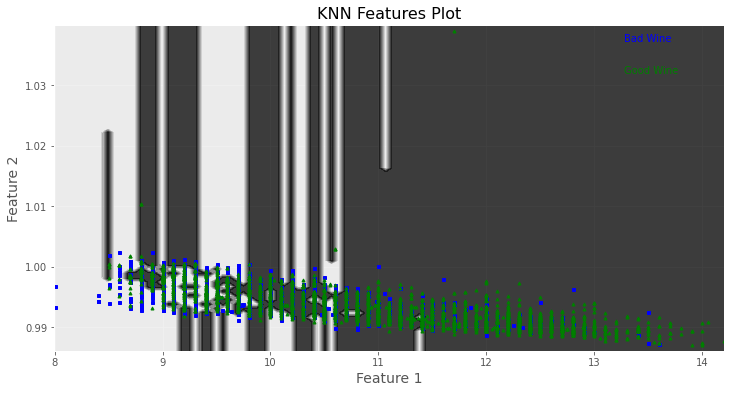


Training Accuracy:  0.9369576314446146

Train Accuracy:  0.9369576314446146
-----------------------------------------

Test Accuracy:  0.7316326530612245

Test Confusion Matrix:
[[185 136]
 [127 532]]

Test Precision = 0.796407
Test Recall = 0.807284
Test F1 Score = 0.801809

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.58      0.58       321
           1       0.80      0.81      0.80       659

    accuracy                           0.73       980
   macro avg       0.69      0.69      0.69       980
weighted avg       0.73      0.73      0.73       980



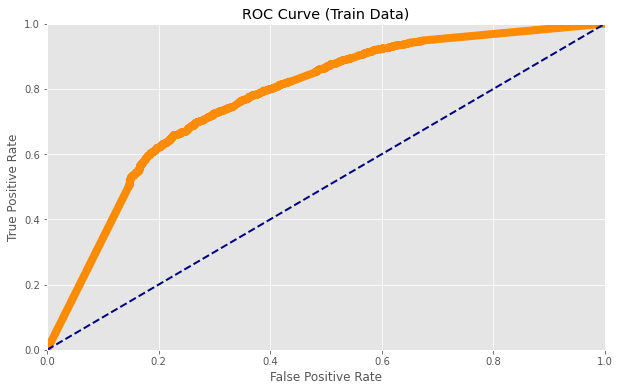

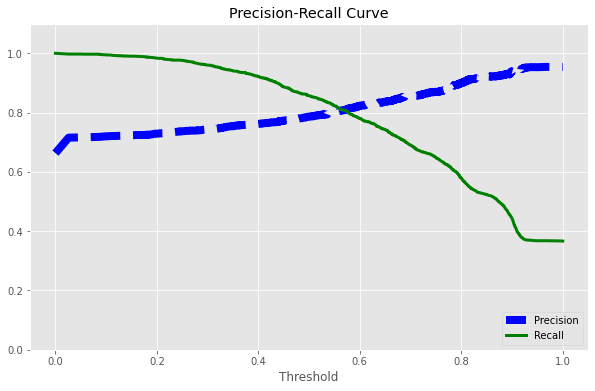

Optimal Threshold:  0.5683203915948767

Test Accuracy:  0.7316326530612245

No. of correct predictions (Test): 717/980

Confusion Matrix (Test Data):
 [[185 136]
 [127 532]]
Precision = 0.796407
Recall = 0.807284
F1 Score = 0.801809


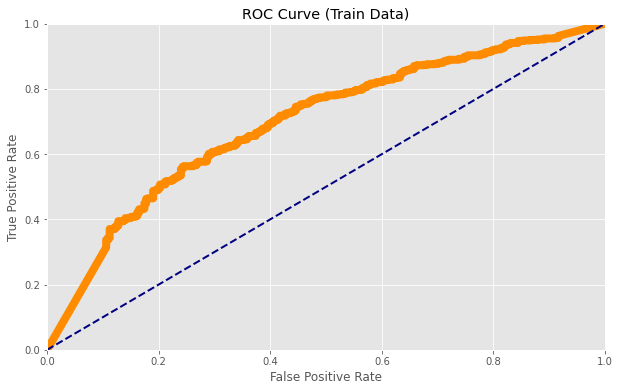

Area under curve: 0.6961316825738989
              precision    recall  f1-score   support

           0       0.59      0.58      0.58       321
           1       0.80      0.81      0.80       659

    accuracy                           0.73       980
   macro avg       0.69      0.69      0.69       980
weighted avg       0.73      0.73      0.73       980



In [76]:
knn_report("alcohol", "density")

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 440 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1080 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 1976 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  1.1min finished


Optimal Hyperparameter Values:  {'n_neighbors': 49, 'p': 10, 'weights': 'uniform'}




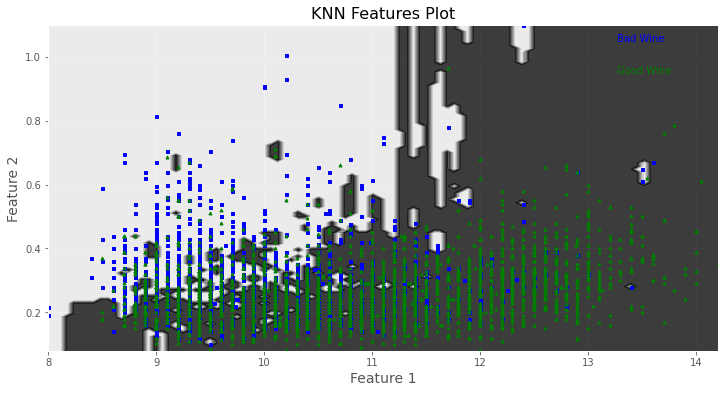


Training Accuracy:  0.844818785094436

Train Accuracy:  0.844818785094436
-----------------------------------------

Test Accuracy:  0.7285714285714285

Test Confusion Matrix:
[[193 128]
 [138 521]]

Test Precision = 0.802773
Test Recall = 0.790592
Test F1 Score = 0.796636

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.60      0.59       321
           1       0.80      0.79      0.80       659

    accuracy                           0.73       980
   macro avg       0.69      0.70      0.69       980
weighted avg       0.73      0.73      0.73       980



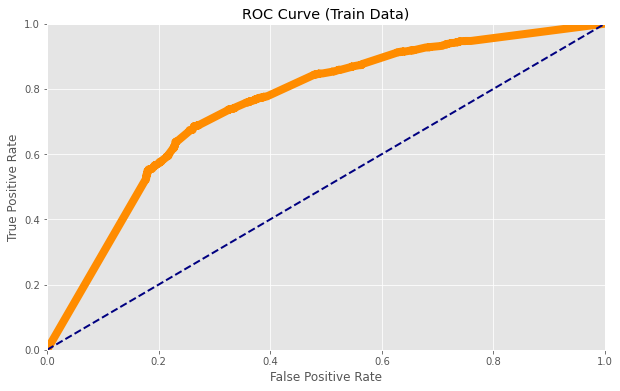

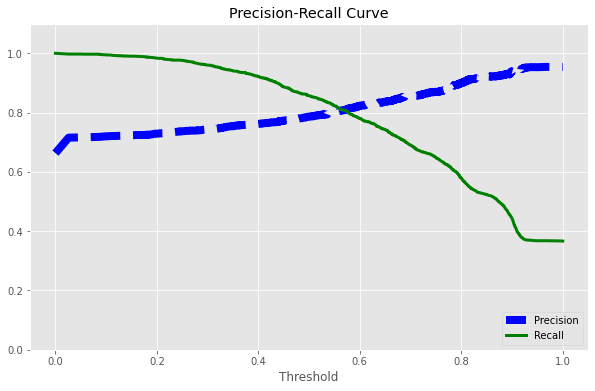

Optimal Threshold:  0.5683203915948767

Test Accuracy:  0.7285714285714285

No. of correct predictions (Test): 714/980

Confusion Matrix (Test Data):
 [[193 128]
 [138 521]]
Precision = 0.802773
Recall = 0.790592
F1 Score = 0.796636


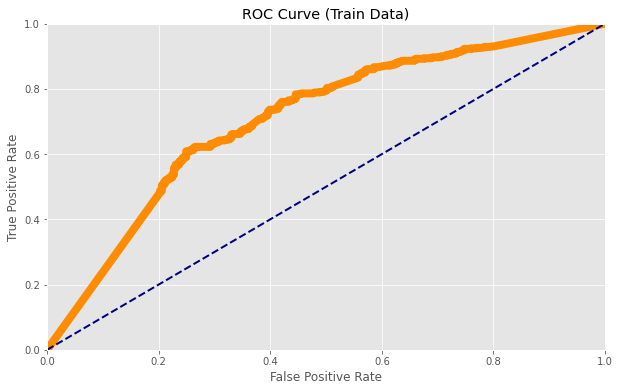

Area under curve: 0.7070942001238543
              precision    recall  f1-score   support

           0       0.58      0.60      0.59       321
           1       0.80      0.79      0.80       659

    accuracy                           0.73       980
   macro avg       0.69      0.70      0.69       980
weighted avg       0.73      0.73      0.73       980



In [77]:
knn_report("alcohol", "volatile acidity")

In [64]:
def decision_boundary_class_colored(clf, X, plotDistanceFromHyperplane=False, colorBar=False):
    
    # Get the min and max value of feature x1
    x1min, x1max = X.iloc[:,0].min() - 0.01, X.iloc[:, 0].max() + 0.01
    
    # Get the min and max value of feature x2
    x2min, x2max = X.iloc[:,1].min() - 0.01, X.iloc[:, 1].max() + 0.01
    
    # Create the mesh grid
    x1s = np.linspace(x1min, x1max, 100)
    x2s = np.linspace(x2min, x2max, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    
    # Create pairs of new points from the grid
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    # Compute the class predictions for all new points
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    
    # Generate the contourf plot for the predictions
    plt.contourf(x1, x2, y_pred, cmap=plt.cm.binary, alpha=0.8)
    
    
    if(plotDistanceFromHyperplane == True):
    
        # Compute the signed distance of a sample to the hyperplane for all new points
        y_decision = clf.decision_function(X_new).reshape(x1.shape)

        # Generate the contourf plot for the distance of all points from the hyperplane
        plt.contourf(x1, x2, y_decision, cmap=plt.cm.bwr, alpha=0.2)
    
    if(colorBar==True):
        plt.colorbar()

In [68]:
def plot_boundary_clf(clf, X):
    plt.figure(figsize=(12, 6))
    
    decision_boundary_class_colored(clf, X)

    plt.plot(X[y==0].iloc[:,0], X[y==0].iloc[:,1], "bs", ms=3)
    plt.plot(X[y==1].iloc[:,0], X[y==1].iloc[:,1], "g^", ms=3)
    
    xmin, xmax = X.min() - 0.001, X.max() + 0.001
    plt.axis([xmin[0], xmax[0], xmin[1], xmax[1]])
    plt.annotate('Bad Wine', xy=(0.85, 0.95), xycoords='axes fraction', color="b")
    plt.annotate('Good Wine', xy=(0.85, 0.85), xycoords='axes fraction', color="g")
    plt.xlabel("Feature 1", fontsize=14)
    plt.ylabel("Feature 2", fontsize=14)
    plt.title("KNN Features Plot", fontsize=16)
    plt.show()

In [74]:
np.arange(1,40,2)

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39])